

# README: Planar Grid Camera Calibration & Radial Distortion Estimation

## Overview
This project provides a robust, fully automated pipeline for estimating camera intrinsics, extrinsics, and radial distortion parameters from a single image of a planar rectangular grid (e.g., tiled floor, printed grid, or checkerboard). The method is designed to work with unknown cameras, unknown distortion, partial occlusion, oblique perspectives, and moderate noise or lighting variation.

## Theory & Mathematical Formulation

### Radial Distortion Model
We use the Brown-Conrady radial distortion model:

$$
\begin{align*}
x_d &= x_u (1 + k_1 r^2 + k_2 r^4) 
y_d &= y_u (1 + k_1 r^2 + k_2 r^4)
\end{align*}
$$

Where:
- $(x_u, y_u)$: undistorted normalized image coordinates
- $(x_d, y_d)$: distorted normalized image coordinates
- $r^2 = x_u^2 + y_u^2$
- $k_1, k_2$: radial distortion coefficients

### Camera Model
- **Intrinsics:** $K = \begin{bmatrix} f_x & 0 & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1 \end{bmatrix}$
- **Extrinsics:** $R$ (rotation), $t$ (translation)
- **Principal Point:** $(c_x, c_y)$

### Cost Function
Minimize the robust reprojection error between detected grid corners $p_i$ and projected model points $\hat{p}_i$:

$$
	ext{Cost} = \sum_{i} \rho\left( \| p_i - \hat{p}_i(K, R, t, k_1, k_2) \|^2 \right)
$$

Where $\rho$ is a robust loss (e.g., Huber) to reduce outlier influence.


## Pipeline functions

1. **Automatic grid corner detection:**
   - The image is processed using Harris corner detection to find all intersection points in the grid, regardless of grid type (not limited to chessboards).
   - Detected corners are visualized and saved as `generic_grid_detected.png`.

2. **Grid size estimation and assignment of model coordinates:**
   - The number of unique rows and columns is estimated from the detected corners.
   - Each detected corner is assigned a model coordinate (row, column) based on its position.

3. **Sorting and matching detected corners to model grid points:**
   - Corners are sorted in row-major order and matched to their corresponding model grid positions.

4. **RANSAC-based outlier removal:**
   - A homography is fitted between model grid points and detected image points using RANSAC.
   - Outlier points (e.g., spurious detections, occluded or noisy corners) are removed, keeping only reliable matches.

5. **Camera intrinsics, extrinsics, and principal point estimation:**
   - Using the inlier correspondences, OpenCV's calibration routine estimates the camera's intrinsic parameters (focal lengths, principal point) and extrinsic parameters (rotation, translation).

6. **Radial distortion parameter estimation:**
   - The Brown-Conrady model is used to estimate radial distortion coefficients ($k_1$, $k_2$) that best explain the observed deviations from ideal projection.

7. **Robust non-linear optimization:**
   - All parameters (intrinsics, extrinsics, distortion) are refined by minimizing a robust cost function (Huber loss) on the reprojection error between detected and predicted grid points.

8. **Image undistortion and computation of undistorted grid:**
   - The estimated parameters are used to undistort the input image, producing `undistorted_grid.jpg`.
   - The undistorted grid is computed and can be visualized for validation.

9. **Reprojection error computation and reporting:**
   - The undistorted grid points are reprojected back into the original image using the estimated distortion model.
   - The residuals (pixel errors) between detected and predicted positions are computed and reported (mean and standard deviation).

10. **Visualization outputs:**
    - `generic_grid_detected.png`: Shows detected grid corners on the original image.
    - `undistorted_grid.jpg`: Shows the undistorted image using the estimated camera and distortion parameters.
    - Console output: Reports grid size, distortion coefficients, and reprojection error statistics.

## Practical Notes
- The pipeline works for any rectangular grid, including tiled floors, printed grids, or checkerboards.
- The grid does not need to be perfectly visible or aligned; partial occlusion and perspective distortion are handled.
- Harris corner detection may detect spurious points; RANSAC and robust optimization mitigate this.
- The code auto-estimates grid size and matches detected corners to model coordinates.
- Outputs include visualizations and quantitative error metrics for validation.

## How to Run
1. Place your grid image (e.g., `3.jpg`) in the project directory.
2. Install dependencies:
   ```bash
   pip install numpy opencv-python scipy
   ```
3. Run the notebook `Camera_Grid_Calibration.ipynb`.
   - The pipeline will auto-detect grid corners, estimate parameters, and output results.

## Outputs
- `generic_grid_detected.png`: Visualization of detected grid corners
- `undistorted_grid.jpg`: Undistorted image using estimated parameters
- Console output: Estimated grid size, distortion coefficients, mean and std reprojection error

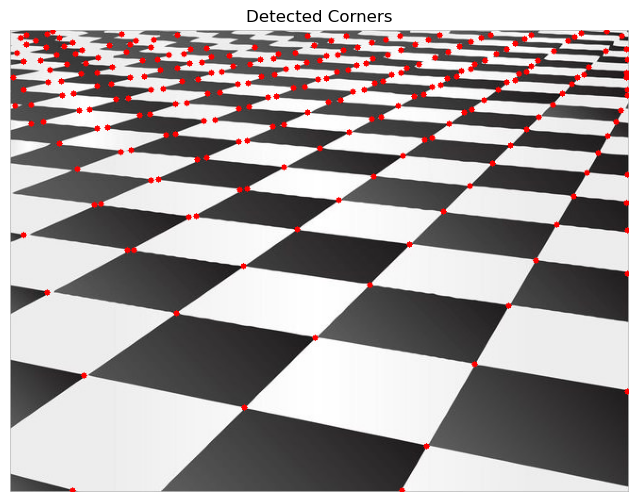

Estimated grid size: (65, 38)
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.3959e+02                                    6.01e+03    
       1              9         1.7827e+02      6.13e+01       9.54e-02       3.75e+03    
       2             11         1.5042e+02      2.79e+01       2.38e-02       5.16e+03    
       3             12         1.3955e+02      1.09e+01       2.38e-02       3.29e+03    
       4             13         1.3473e+02      4.82e+00       2.38e-02       2.64e+03    
       5             14         1.2939e+02      5.34e+00       2.38e-02       1.25e+03    
       6             15         1.2253e+02      6.86e+00       4.77e-02       5.05e+02    
       7             16         1.1295e+02      9.58e+00       9.54e-02       6.33e+02    
       8             17         1.0171e+02      1.12e+01       1.91e-01       9.75e+02    
       9             18         8.5979e+01      1.57e+01    

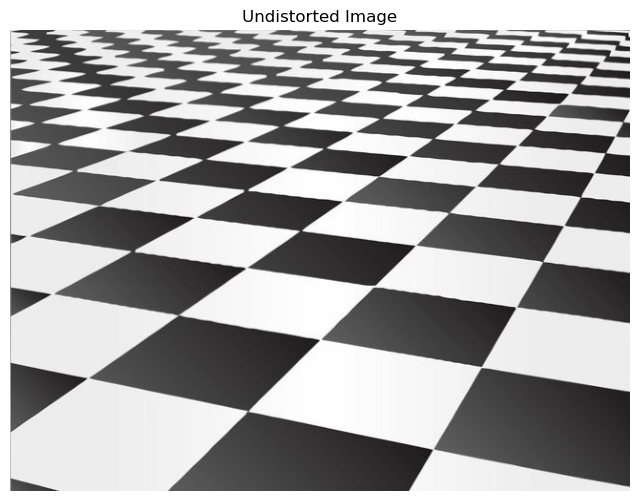

In [ ]:
import cv2
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

# This function finds the intersection points (corners) in a generic rectangular grid image.
# It uses Harris corner detection, which is good for finding sharp changes in intensity.
# The function also saves a visualization of detected corners for sanity checking.
def detect_grid_corners(image_path):
    # Load the color image and make a grayscale copy for processing
    img_color = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
    # Improve contrast to make corners more visible
    img = cv2.equalizeHist(img)
    # Blur the image slightly to reduce noise
    img = cv2.GaussianBlur(img, (5, 5), 0)
    # Harris corner detection algorithm
    dst = cv2.cornerHarris(img, 2, 3, 0.04)
    # Make the detected corners more prominent
    dst = cv2.dilate(dst, None)
    # Threshold to get binary image of corners
    ret, dst_bin = cv2.threshold(dst, 0.01 * dst.max(), 255, 0)
    dst_bin = np.uint8(dst_bin)
    # Find connected components (clusters of pixels) in the binary image
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst_bin)
    # Remove the first centroid, which is the background
    centroids = centroids[1:]
    # Draw detected corners on a color copy for visualization
    vis = img_color.copy()
    for c in centroids:
        cv2.circle(vis, (int(c[0]), int(c[1])), 3, (0, 0, 255), -1)
    cv2.imwrite("generic_grid_detected.png", vis)
    # Display detected corners inline (Jupyter)
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Detected Corners")
    plt.show()
    # Return the centroids, the processed grayscale image and original color image
    return centroids, img, img_color

# This function applies the Brown-Conrady radial distortion model.
# It takes normalized coordinates and distortion parameters, and returns distorted coordinates.
def brown_conrady_distortion(xu, yu, k1, k2):
    r2 = xu**2 + yu**2
    factor = 1 + k1 * r2 + k2 * r2**2
    xd = xu * factor
    yd = yu * factor
    return xd, yd

# This function projects 3D grid points to 2D image points using camera parameters,
# then applies the distortion model to simulate how the camera "sees" the grid.
def project_and_distort(objp, params):
    fx, fy, cx, cy, k1, k2 = params[:6]
    rvec = params[6:9].reshape(3, 1)
    tvec = params[9:12].reshape(3, 1)
    K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
    # Project points using OpenCV's function (no distortion yet)
    pts, _ = cv2.projectPoints(objp, rvec, tvec, K, np.zeros(5))
    pts = pts.squeeze()
    # Convert to normalized coordinates (relative to principal point and focal length)
    xu = (pts[:, 0] - cx) / fx
    yu = (pts[:, 1] - cy) / fy
    # Apply the distortion model
    xd, yd = brown_conrady_distortion(xu, yu, k1, k2)
    # Convert back to pixel coordinates
    x_pix = xd * fx + cx
    y_pix = yd * fy + cy
    return np.vstack([x_pix, y_pix]).T

# This function computes the reprojection error between detected and modeled points.
# It uses Huber loss to reduce the influence of outliers (robust optimization).
def robust_reprojection_error(params, objp, img_pts):
    proj_pts = project_and_distort(objp, params)
    residuals = proj_pts - img_pts
    delta = 1.0
    abs_res = np.abs(residuals)
    loss = np.where(abs_res < delta, 0.5 * residuals**2, delta * (abs_res - 0.5 * delta))
    return loss.ravel()

# This is the main pipeline for grid-based camera calibration and distortion estimation.
def main(image_path):
    # Step 1: Detect grid corners in the image (also get original color image)
    centroids, img, img_color = detect_grid_corners(image_path)
    # Step 2: Estimate grid size by clustering detected corners
    x_coords = np.sort(centroids[:, 0])
    y_coords = np.sort(centroids[:, 1])
    x_unique = np.unique(np.round(x_coords, -1))
    y_unique = np.unique(np.round(y_coords, -1))
    nx = len(x_unique)
    ny = len(y_unique)
    print(f"Estimated grid size: ({nx}, {ny})")
    # Step 3: Assign model grid coordinates to detected centroids
    objp = np.zeros((len(centroids), 3), np.float32)
    # Sort centroids so that their order matches the grid (row-major)
    idx_sorted = np.lexsort((centroids[:, 0], centroids[:, 1]))
    centroids_sorted = centroids[idx_sorted]
    # Assign grid coordinates by finding closest row/column for each centroid
    for i, c in enumerate(centroids_sorted):
        row = np.argmin(np.abs(y_unique - c[1]))
        col = np.argmin(np.abs(x_unique - c[0]))
        objp[i, :2] = [col, row]
    img_pts = centroids_sorted
    # Step 4: Use RANSAC to fit a homography and remove outlier points
    H, mask = cv2.findHomography(objp[:, :2], img_pts, cv2.RANSAC)
    inliers = mask.ravel().astype(bool)
    objp_inliers = objp[inliers].astype(np.float32)
    img_pts_inliers = img_pts[inliers].astype(np.float32)
    img_pts_inliers = img_pts_inliers.reshape(-1, 1, 2)
    # Step 5: Estimate initial camera parameters using OpenCV's calibration
    ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(
        [objp_inliers], [img_pts_inliers], img.shape[::-1], None, None
    )
    fx, fy = K[0, 0], K[1, 1]
    cx, cy = K[0, 2], K[1, 2]
    k1, k2 = dist[0, 0], dist[0, 1]
    rvec, tvec = rvecs[0], tvecs[0]
    # Step 6: Refine all parameters using robust non-linear optimization
    init_params = np.hstack([fx, fy, cx, cy, k1, k2, rvec.ravel(), tvec.ravel()])
    result = least_squares(
        robust_reprojection_error, init_params,
        args=(objp_inliers, img_pts_inliers.reshape(-1, 2)),
        loss='huber', verbose=2, max_nfev=2000
    )
    # Step 7: Undistort the original color image using the estimated parameters
    K_opt = np.array([[result.x[0], 0, result.x[2]], [0, result.x[1], result.x[3]], [0, 0, 1]], dtype=np.float64)
    dist_opt = np.array([result.x[4], result.x[5], 0.0, 0.0, 0.0], dtype=np.float64)
    # Compute an optimal new camera matrix to preserve more image area after undistortion
    newK, roi = cv2.getOptimalNewCameraMatrix(K_opt, dist_opt, (img_color.shape[1], img_color.shape[0]), 1)
    undistorted_img = cv2.undistort(img_color, K_opt, dist_opt, None, newK)
    # crop to ROI if returned
    x, y, w, h = roi
    if w > 0 and h > 0:
        undistorted_img = undistorted_img[y:y+h, x:x+w]
        img_color_disp = img_color[y:y+h, x:x+w]
    else:
        img_color_disp = img_color
    # Step 8: Reproject the undistorted grid and compute residuals
    reprojected = project_and_distort(objp_inliers, result.x)
    residuals = np.linalg.norm(reprojected - img_pts_inliers.reshape(-1, 2), axis=1)
    mean_error = np.mean(residuals)
    std_error = np.std(residuals)
    print(f"Mean reprojection error: {mean_error:.3f} pixels")
    print(f"Std reprojection error: {std_error:.3f} pixels")
    print(f"Estimated distortion coefficients: k1={result.x[4]:.5f}, k2={result.x[5]:.5f}")
    # Save the undistorted image for inspection
    cv2.imwrite("undistorted_grid.jpg", undistorted_img)
    # Display only the undistorted image
    plt.figure(figsize=(8, 6))
    if undistorted_img.ndim == 2:
        plt.imshow(undistorted_img, cmap="gray")
    else:
        plt.imshow(cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Undistorted Image")
    plt.show()

if __name__ == "__main__":
    main("test-images/3.jpg")